In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# Deep Neural Networks 
## Session 02a


## Implementation of Single Layer

<img src='../../prasami_images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align = "left"/>

## 1. Import Statements

In [2]:
###-----------------
### Import Libraries
###-----------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn import datasets
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

## 2. Setup Global Parameters

In [3]:
###----------------
### Some parameters
###----------------

# Directory locations
inpDir = '../../input'
outDir = '../output'

RANDOM_STATE = 24 # REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE)
rng = np.random.default_rng(seed = RANDOM_STATE) # Set Random Seed for reproducible  results

NOISE = 0.2
EPOCHS = 200  # number of epochs
ALPHA = 0.001  # learning rate
N_SAMPLES = 1000

# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'medium',
          'axes.titlesize':'medium',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## 3. Generate Data Set
<div style="font-family: Arial; font-size:1.2em;">
Sklearn's dataset generator is good source of data for learning. To keep the example simple, I'll suggest  <a href="http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html">make_moon</a> dataset generator.
</div>

In [4]:
X, y = datasets.make_moons(n_samples=N_SAMPLES, 
                           shuffle=True, 
                           noise=NOISE, 
                           random_state=RANDOM_STATE)
X[:5], y[:5]

(array([[ 0.90633951,  0.90267624],
        [-1.11536828,  0.75579289],
        [ 1.88769158,  0.4175967 ],
        [-0.93345034, -0.02299851],
        [-0.96872877,  0.06396285]]),
 array([0, 0, 1, 0, 0]))

## 4. Visualization
<p style="font-family: Arial; font-size:1.2em;">
DataFrames are easier to visualize
</p>

In [5]:
data_df = pd.DataFrame(X, columns = ['A', 'B'])

data_df['target'] = y

data_df.head()

,A,B,target
0,0.906340,0.902676,0
1,-1.115368,0.755793,0
2,1.887692,0.417597,1
3,-0.933450,-0.022999,0
4,-0.968729,0.063963,0


In [6]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A       1000 non-null   float64
 1   B       1000 non-null   float64
 2   target  1000 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 23.6 KB


In [7]:
data_df.describe() # Generate descriptive statistic

,A,B,target
count,1000.000000,1000.000000,1000.00000
mean,0.490841,0.239025,0.50000
std,0.898951,0.540082,0.50025
min,-1.688795,-0.955280,0.00000
25%,-0.149565,-0.205090,0.00000
50%,0.500100,0.241163,0.50000
75%,1.095048,0.680394,1.00000
max,2.419113,1.612075,1.00000


In [8]:
# what labels are present?
data_df.target.unique()

array([0, 1])

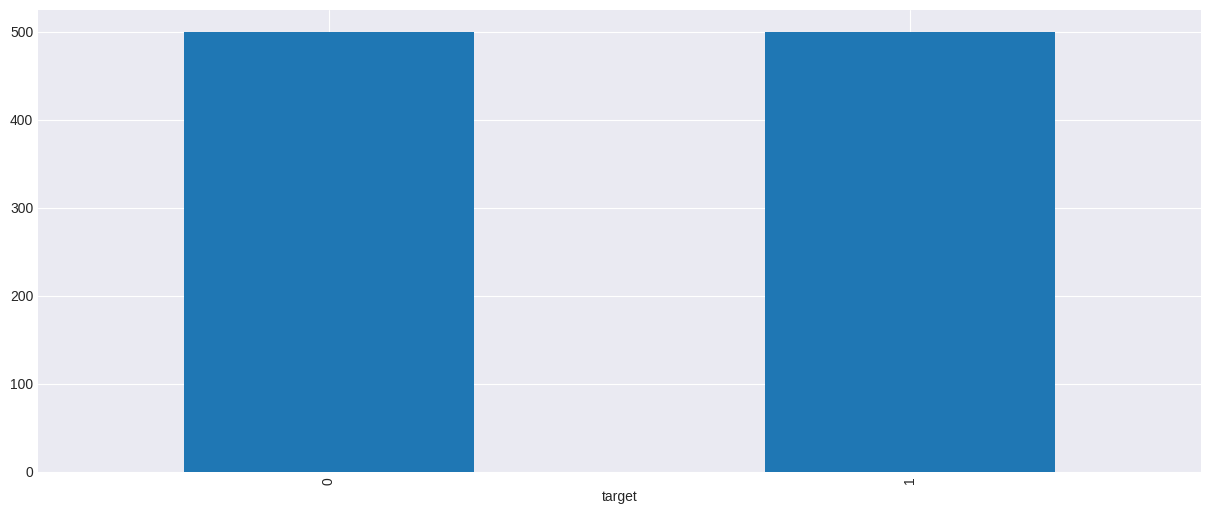

In [9]:
fig, ax = plt.subplots() # Instantiate
    
data_df['target'].value_counts().plot(ax=ax, kind='bar');

### 4.1 Different ways of plotting data

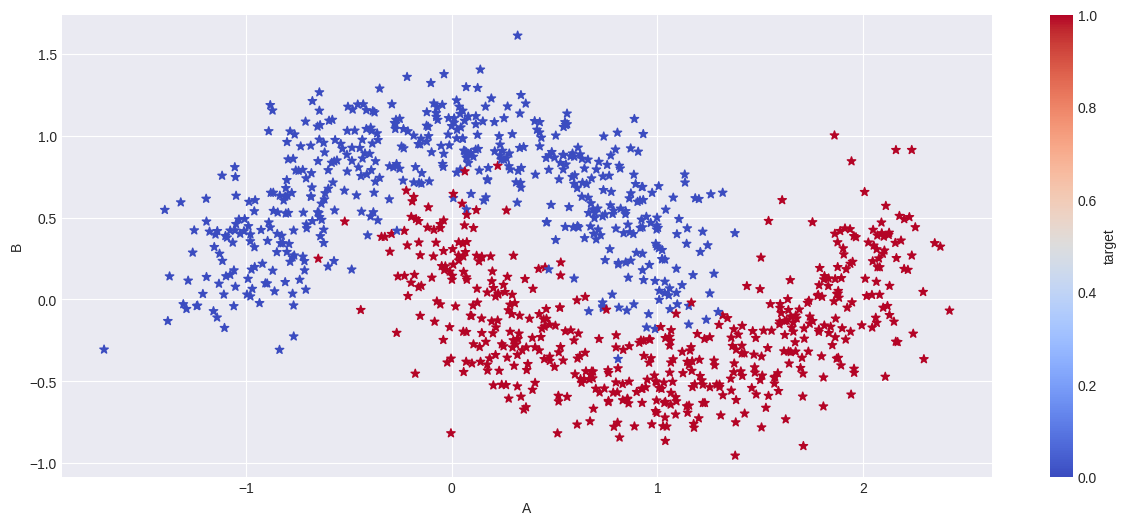

In [10]:
# Plot the data
data_df.plot.scatter('A', 'B', 
                     s=40,
                     marker = '*', 
                     c = 'target',
                     cmap=CMAP);

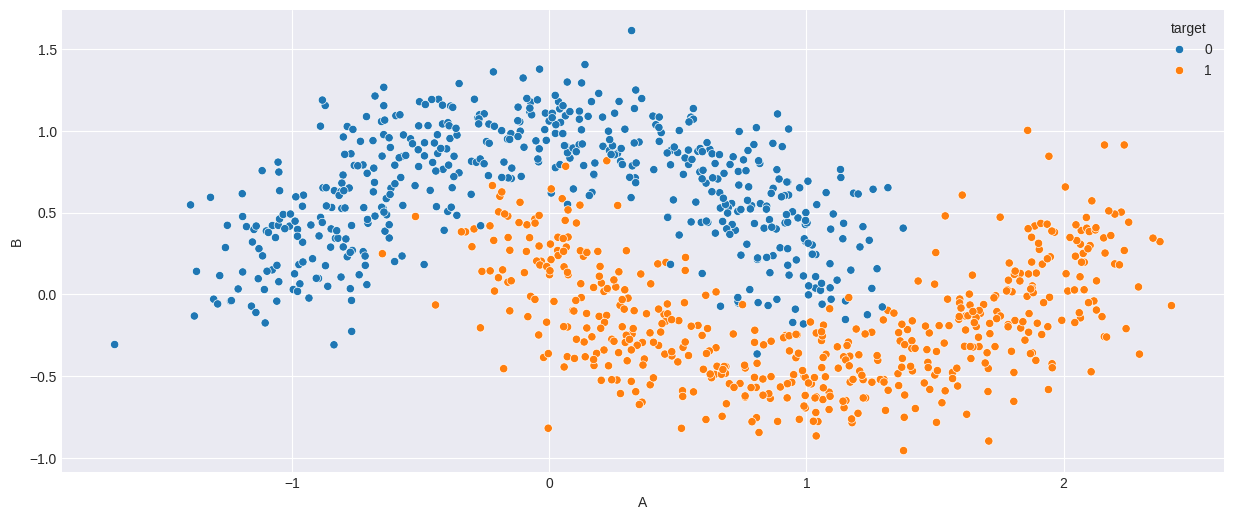

In [11]:
# Using Seaborn
ax = sns.scatterplot(x='A', y='B', data=data_df, hue='target');

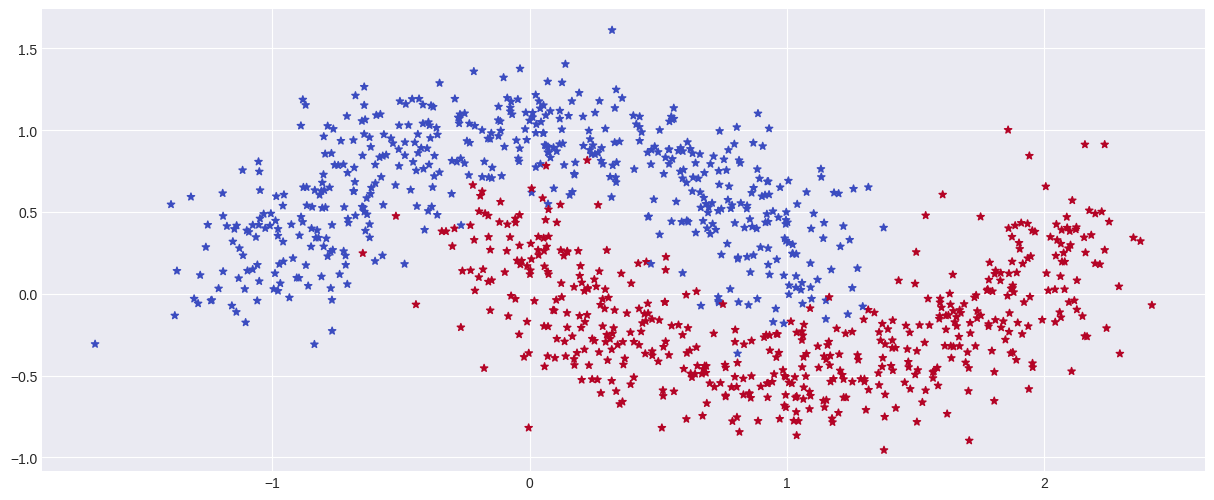

In [12]:
#### In case you want to plot X Array directly
plt.scatter(X[:,0], X[:,1], s=30, c=y, marker = '*', cmap=CMAP);

<div style="font-family: Arial; font-size:1.2em;">
    We will keep 10%, i.e. 100 records for testing and remaining records will be used in training. Note that the data is already random.
</div>

In [13]:
data_train, data_test = data_df.to_numpy()[:900], data_df.to_numpy()[900:]

print (data_train.shape, data_test.shape)

print (type(data_train), type(data_test))

(900, 3) (100, 3)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


# Over to Perceptron

<div style="font-family: Arial; font-size:1.1em;">

Our output is binary. To keep the code in line with what we discussed in previous lecture, we will simply output 1 for positive values of 'z' and zero for negative values.
</div>

<img src="../../images/dnn_nb_s03_fig1.jpg" width='350' align = 'left'>


$$
\begin{aligned}
z & = 1.0 \circ w_0 + x_1 \circ w_1 + x_2 \circ w_2 \\
\mathrm{or}\\
z & = X\circ W \\
\end{aligned}
$$
<br/>


$$
\begin{equation*}
    \hat{y} = \begin{cases}
      1.0, & \text{for z>=0}\  \\
      0.0, & \text{for z<0}\
    \end{cases}
\end{equation*}
$$

As we know that adjustments in the weights are ($\hat{y}$ - y) or (a-y). We don't want to adjust by full value. It makes convergence easier if we adjust by a small fraction.
- **Why?** We would know better all through this module. We will circle back to `learning_rate` after some sessions.

Let's assume that adjusting weights by $\alpha$ * ( a - y ) makes better sense.
**Note:** Take learning_rate ($\alpha$) as some constant.

## 5. Prediction

In [14]:
# A function to make predictions

def predict(row: np.ndarray, weights : np.ndarray) -> np.float64:
    '''
    Args: 
        row: one data row.
        weights: array with first value as b and then w1 and w2.
    return:
        0 if sum is negative else 1. Simplest form of activation function.
    '''
    
    # building up z = X * W + b
    z = weights[0] # Initialize with b, bias
    
    for i in range(len(row)-1):
        
        z += weights[i + 1] * row[i] # and weights are added here to the values

    return 1 if z >=0  else 0 # simplest form of activation function

**Its advisable to test the function**

In [15]:
#Unit test
weights = np.array([0.1, 2.0, 1.0])

display(data_df.loc[0])

predict(data_df.loc[0].values, weights)

A         0.906340
B         0.902676
target    0.000000
Name: 0, dtype: float64

1

<div style="font-family: Arial; font-size:1.1em;">
    <h3>Back-propagation - Estimate Perceptron weights </h3>
<div>

$
\begin{aligned}
\partial{z}  & = a - y \\
\partial{b}  & = \partial{z} \\
\partial{w_1}  & = x_1 \circ \partial{z}\\
\partial{w_2}  & = x_2 \circ \partial{z}\\
\end{aligned}
$

$
\begin{aligned}
b & = b -  \frac{1}{m} (\alpha \circ \partial{b}) \\
w_1  & = w_1 - \frac{1}{m}(\alpha \circ \partial{w_1} )\\
w_2  & = w_2 - \frac{1}{m}(\alpha \circ \partial{w_2} )\\
\end{aligned}
$

 
 ## 6. Training

In [ ]:
def train_weights(train : np.ndarray, alpha : np.float64, n_epoch: np.int64):
    '''
    Args: 
        train: training dataset
        alpha: learning rate
        n_epoch: number of epoch to train
    return:
        errors: list containing errors
        weights: list of updated weights
    '''
    
    # We will be appending errors in a list
    errors = []
    
    #Initialize Weights. In theory b can be zero. For sake of simplicity, let's initialize b as well.         
    weights = rng.random(train.shape[1])
    
    # find m; number of samples
    m = train.shape[0]
    
    for epoch in range(n_epoch): # loop for number of epochs
        
        sum_error = 0.0
        
        ###---------------------------------------------------
        ### Note: we are adjusting weights in each of the row.
        ### It is one of the techniques of optimization
        ### More optimization techniques later
        ###---------------------------------------------------
        for row in train:
            
            prediction = predict(row, weights) # make prediction by row
                
            dz = prediction - row[-1] # dz = (a-y) 
            
            sum_error += (prediction - row[-1])**2 # cumulative error for this epoch
            
            # In batch processing we would have updated once for every batch
            # In stochastic gradient descend, we update for each training example.
            
            weights[0] = weights[0] - alpha * dz  # update b
            
            for i in range(len(row)-1):
                
                weights[i + 1] = weights[i + 1] - alpha * dz * row[i] # update rest of the weights
        
        errors.append(sum_error / m) # append average error
        
    return errors, weights

In [17]:
# calling 'train_weight'

errors, weights = train_weights(data_train, ALPHA, EPOCHS)

print(weights)

[-0.00073116  0.00252746 -0.00400164]


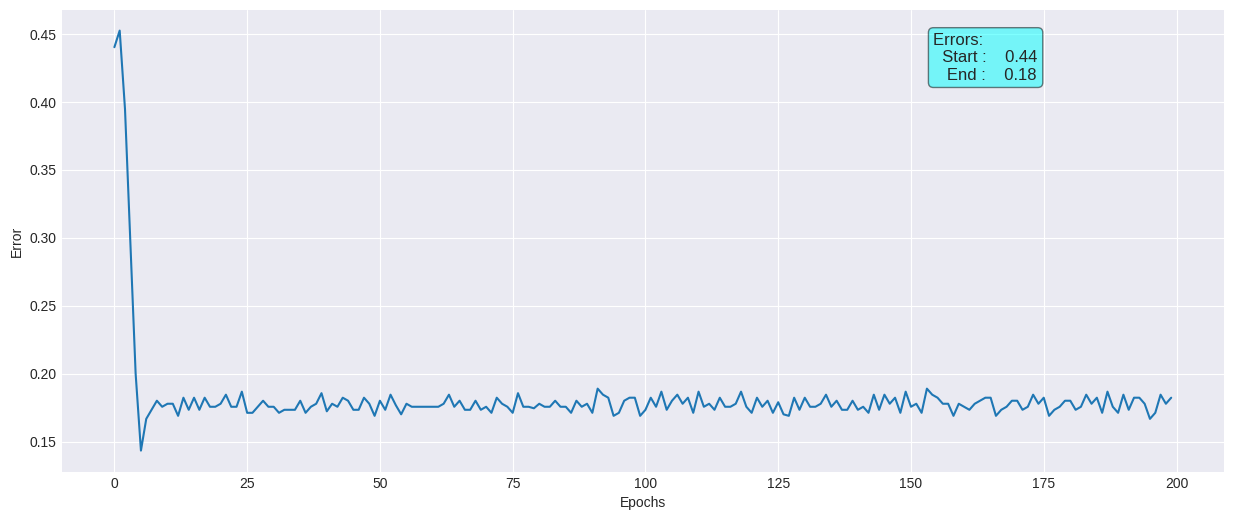

In [ ]:
fig, ax = plt.subplots()
ax.plot(errors)

# Little beautification
txtstr = "Errors: \n  Start : {:7.2f}\n   End : {:7.2f}".format(errors[0],errors[-1]) #text to plot

# Properties  matplotlib.patch.Patch 
props = dict(boxstyle='round', facecolor='cyan', alpha=0.5)

# Place a text box in upper left in axes coords

ax.text(0.75, 0.95, txtstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

# Labeling the Plot
ax.set_xlabel("Epochs")
ax.set_ylabel("Error");

## Question
<div style="font-family: Arial; font-size:1.2em;">
Why do we keep training and not stop at min training error? Hold on! We would get to that eventually.
</div>

## 7. Predictions

### Train Set

In [19]:
predictions = []

for row in data_train:
    
    prediction = predict(row, weights)
    
    predictions.append(prediction)

In [20]:
accuracy_score(data_train[:,-1], predictions)

0.84

### Test Set

In [21]:
predictions = []

for row in data_test:
    
    prediction = predict(row, weights)
    
    predictions.append(prediction)

In [22]:
accuracy_score(data_test[:,-1], predictions)

0.89

In [23]:
cm = confusion_matrix(data_test[:,-1], predictions)
cm

array([[54,  4],
       [ 7, 35]])

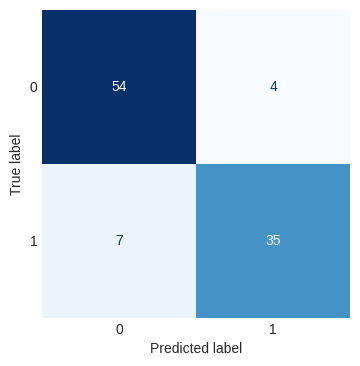

In [24]:
# Create plot object of confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])

# initialize figure
fig, ax = plt.subplots(figsize = (4,4))

#Plot 
disp.plot(ax = ax, cmap = 'Blues', colorbar=False)
plt.grid()
plt.show();

In [25]:
def fn_plot_decision_boundary(X: np.ndarray):
    
    # initialize the figure
    fig, ax = plt.subplots(figsize = (8,5));
    
    # Small increment to create object function surface
    dm = 0.05
    
    # Range of X values (First feature)
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    
    # Range of Y values (Second feature)
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    
    # Create a grid to evaluate the object function
    xx, yy = np.meshgrid(np.arange(x_min, x_max, dm),
                         np.arange(y_min, y_max, dm))
    
    # flatten and stack
    # arrays will be stacked along their last axis after being upgraded to at least 2-D 
    # with 1’s post-pended to the shape (column vectors made out of 1-D arrays)
    XX = np.c_[xx.ravel(), yy.ravel()] 

    # add another column filled with 1 to make it work with the predict function
    XX = np.hstack( ( XX, np.ones((XX.shape[0],1)) ) )
    
    # list to collect predictions
    y_pred = []
    
    # Iterate over rows
    for row in (XX):

        y_p = predict(row, weights)
        y_pred.append(y_p)
        
    Z = np.array(y_pred).reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.6, cmap=plt.cm.Paired)
    ax.scatter(X[:, 0], X[:, 1], c=X[:, 2],
                                  s=20, edgecolor='k', cmap=plt.cm.bwr)
    ax.set_title('Decision Boundary')

    ax.set_xlabel('A')
    ax.set_ylabel('B')
    plt.show()

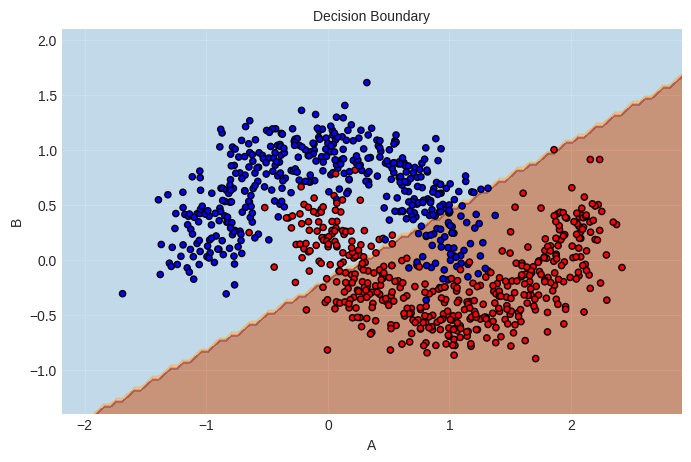

In [26]:
fn_plot_decision_boundary(data_train)

## Tracking
<div style="font-family: Arial; font-size:1.2em;">
Lets track the results across various implementations...

 |#|Implementation|Training Accuracy|Testing Accuracy|Remarks|
 |:-:|---|---|---|---|
 |1|Simple Perceptron|0.83111|0.89000||

## Notes:

## A note on Loss Function

In logistic regression, we are trying to find out whether something belongs to a certain class or not.

We treat the model’s output, $\hat{y}$, as the probability that the correct answer is yes (i.e., $y = 1$), given the input $X$.
So,
$\hat{y}=p(y=1∣X)$

Example:
Suppose we want to check if there is a car in a picture.
Then, $\hat{y}$ is the probability that the picture has a car.

Mathematically:
If $X$ is a training example (like the picture), then
$\hat{y}=p(y=1∣X)$

This means we are asking: "What is the chance that the answer is yes (there is a car), given this picture?"

Two possible cases:
* If there is a car in the picture ($y = 1$), then the chance is:
    $p(y∣X)=\hat{y}$
* If there is no car in the picture ($y = 0$), then the chance is:
    $p(y∣X)=1−\hat{y}$

### Understanding the Loss Function in Logistic Regression

We already know that:
* $\hat{y}$ is the model’s predicted probability that $y = 1$
* So, if $\hat{y}$ is the chance that $y = 1$, then $(1 - \hat{y})$ is the chance that $y = 0$

<b>Combining Both Cases into One Equation:</b>

We can write a single equation that works for both $y = 1$ and $y = 0$: $p(y|X)$ = $\hat{y}^{y} * (1 - \hat{y}) ^{(1-y)}$

#### Explanation:
* If $y = 1$, the formula becomes: $\hat{y}^1 \cdot (1 - \hat{y})^0 = \hat{y}$
* If $y = 0$, it becomes: $\hat{y}^0 \cdot (1 - \hat{y})^1 = 1 - \hat{y}$
So this one formula covers both cases.


####  Taking the Logarithm

To simplify calculations (and because it's easier to work with sums than products), we take the log of the equation:
$log⁡[p(y∣X)]=y⋅log⁡(\hat{y})+(1−y)⋅log⁡(1−\hat{y})$

### Defining the Loss Function

Since we want to minimize the loss, we take the negative of the log:

$L(\hat{y},y)=−[y⋅log⁡(\hat{y})+(1−y)⋅log⁡(1−\hat{y})]$

This is called the binary cross-entropy loss function.

Sometimes, $\hat{y}$ is also written as $a$ (for activation), so the formula may also be written as:

$
\begin{aligned}
L(a,y) =  - [ y * log ( a ) + ( 1 - y ) * log( 1 - a ) ]\\
\end{aligned}
$

Since we aim to minimize above function, add negative sign and our loss function becomes


|Case| y |Loss| a |-log(a)|-log(1-a)|
|:-: |:-:|:-: |:-:|  :-: |   :-:  |
| 1  | 0 | -log( 1 - a )| 0.000001 |13.8155|**1 e-6**|
| 2  | 0 | -log( 1 - a )| 0.999999 |1 e-6|**13.8155**|
| 3  | 1 | -log( a )| 0.000001 |**13.8155**|1 e-6|
| 4  | 1 | -log( a )| 0.999999 |**1 e-6**|13.8155|


For binary classification the error = - $y * log(a)$. We want to sum it up for all samples in the dataset. Hence:

$
\begin{aligned}
p(\text{all ys | all rows of x}) & =  \Pi_{i=0}^m p(y^i|x^i)\\
log [ p(\text{all ys | all rows of x})] & =  log [ \Pi_{i=0}^m p(y^i|x^i) ]\\
& =  \sum_{i=0}^m log [ p(y^i|x^i) ]
\end{aligned}
$

Hence for multi-class classification:

$
\begin{aligned}
p(\text{all ys | all rows of x}) & =  \sum_{i=0}^m [ y * log(\hat{y}) + (1-y) * log(1 - \hat{y}) ]\\
\text{Divide it by m to better scale the costs}\\
& = \frac{1}{m} * \sum_{i=0}^m [ y * log(\hat{y}) + (1-y) * log(1 - \hat{y}) ]\\
\end{aligned}
$

### Introducing $\mathrm{sigmoid}$ function for our binary output.
$$
\begin{align}
z &= x_1 . w_1 + x_2 . w_2 + b_1 \\
a &= \hat{y} = \sigma(z)\\
dz &= (a - y) \\
db &= dz\\
b &= b - \alpha . db\\
dw_1 &= x_1. dz\\
dw_2 &= x_2.dz\\
w_1 &= w_1 - \alpha . dw_1\\
w_2 &= w_2 - \alpha . dw_2\\
\end{align}
$$
### Sigmoid function
$$
\begin{align}
a &= \sigma(z)\\
&= \dfrac{1}{1 + e^{-z}}\\
\end{align}
$$
## Derivative of sigmoid function
$$
\begin{align}
\partial{a} &= \partial{\sigma(z)}\\
&= \dfrac{\partial}{\partial{z}} \left[ \dfrac{1}{1 + e^{-z}} \right] \\
&= \dfrac{\partial}{\partial{z}} \left( 1 + \mathrm{e}^{-z} \right)^{-1} \\
&= -(1 + e^{-z})^{-2}(-e^{-z}) \\
&= \dfrac{e^{-z}}{\left(1 + e^{-z}\right)^2} \\
&= \dfrac{1}{1 + e^{-z}\ } \circ \dfrac{e^{-z}}{1 + e^{-z}}  \\
&= \dfrac{1}{1 + e^{-z}\ } \circ \dfrac{(1 + e^{-z}) - 1}{1 + e^{-z}}  \\
&= \dfrac{1}{1 + e^{-z}\ } \circ \left[ \dfrac{1 + e^{-z}}{1 + e^{-z}} - \dfrac{1}{1 + e^{-z}} \right] \\
&= \dfrac{1}{1 + e^{-z}\ } \circ \left[ 1 - \dfrac{1}{1 + e^{-z}} \right] \\
&= \sigma(z) \circ (1 - \sigma(z))\\
&= a \circ (1 - a)
\end{align}
$$